<a href="https://colab.research.google.com/github/joherra/MyApplication/blob/master/Proyecto%202.2.%20Modelos%20del%20Horno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- *Asignatura*: Ingeniería del Conocimiento
- *Curso*: 2020/2021
- *Profesor*: Fco. Javier Martínez de Pisón
- Universidad de La Rioja

# Proyecto 2. Diseño de DSS en Industria 4.0 (Parte 2/3)

Continuamos profundizando en el desarrollo de modelos predictivos que puedan ser usados en una planta de galvanizado de bobinas de acero. El objetivo de esta segunda parte consiste en desarrollar modelos que 'aprendan' a determinar la temperatura a la que hay que poner el horno de galvanizado según las dimensiones de la bobina de acero y otras variables objetivo como puede ser la temperatura a la que debe salir la banda de acero (TMPP2CNG) y la velocidad media (VELMED).

Como queremos el modelo del CASO A de predicción de temperaturas de consigna del horno sea suficientemente preciso y eficiente, necesitaremos extraer de la base de datos aquellas observaciones cuya temperatura de salida (TMPP2) frente a la objetivo (TMPP2CNG) tenga una diferencia máxima de 25ºC en valor absoluto. Es decir, vamos a desarrollar unos modelos que “aprendan” de aquellos casos donde las consignas del horno han sido correctas cuando el tratamiento se ha realizado correctamente. En este caso, el modelo aprenderá de los casos donde la bobina ha sido procesada correctamente, tanto en el 'modo manual' como en el 'automático'.

In [3]:
# Importamos paquetes basicos
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff

In [4]:
import sklearn
print(sklearn.__version__)

0.22.2.post1


## Cargamos la Base de Datos y Eliminamos los Casos Anómalos

In [5]:
!wget https://github.com/IC1920/Datasets/raw/master/DATOS_HORNO_ENTRENA.arff -O DATOS_HORNO_ENTRENA.arff
!wget https://github.com/IC1920/Datasets/raw/master/DATOS_HORNO_TESTEO.arff -O DATOS_HORNO_TESTEO.arff

--2021-05-01 15:55:48--  https://github.com/IC1920/Datasets/raw/master/DATOS_HORNO_ENTRENA.arff
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IC1920/Datasets/master/DATOS_HORNO_ENTRENA.arff [following]
--2021-05-01 15:55:48--  https://raw.githubusercontent.com/IC1920/Datasets/master/DATOS_HORNO_ENTRENA.arff
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125832 (123K) [text/plain]
Saving to: ‘DATOS_HORNO_ENTRENA.arff’

DATOS_HORNO_ENTRENA 100%[===================>] 122.88K  --.-KB/s    in 0.03s   

2021-05-01 15:55:48 (4.77 MB/s) - ‘DATOS_HORNO_ENTRENA.arff’ saved [125832/125832]

--2021-05-01

In [6]:
# Leemos los archivos arff
df_train = pd.DataFrame(arff.loadarff("DATOS_HORNO_ENTRENA.arff")[0])
df_test = pd.DataFrame(arff.loadarff("DATOS_HORNO_TESTEO.arff")[0])

In [7]:
df_train['CLASACERO'] = df_train['CLASACERO'].str.decode('utf-8')
df_test['CLASACERO'] = df_test['CLASACERO'].str.decode('utf-8')

df_train['CODBOB'] = df_train['CODBOB'].astype(int)
df_test['CODBOB'] = df_test['CODBOB'].astype(int)

display(df_train.head(3), df_test.head(3))

,CODBOB,CLASACERO,ANCHO,ESPESOR,LARGO,PESO,VELMED,TMPP1,TMPP2,TMPP2CNG,THC1,THC3,THC5
0,23293006,B011F97,1250.0,0.6,3683.0,21770.0,145.0,212.0,754.0,750.0,770.0,800.0,821.0
1,23293007,B011F97,1250.0,0.6,3040.0,18070.0,145.0,210.0,749.0,750.0,772.0,801.0,822.0
2,23293008,B011F97,1250.0,0.6,3605.0,21420.0,138.0,211.0,761.0,770.0,778.0,808.0,833.0


,CODBOB,CLASACERO,ANCHO,ESPESOR,LARGO,PESO,VELMED,TMPP1,TMPP2,TMPP2CNG,THC1,THC3,THC5
0,23633053,B105F55,1040.0,0.7,3491.0,19780.0,136.0,256.0,851.0,850.0,858.0,888.0,914.0
1,23633054,B105F55,1040.0,0.7,3240.0,18370.0,140.0,258.0,850.0,850.0,860.0,890.0,914.0
2,23633055,B105F55,1040.0,0.7,3047.0,17160.0,140.0,260.0,850.0,850.0,860.0,890.0,914.0


In [8]:
df_train = df_train.loc[df_train['VELMED']<500] # Nos quedamos con los casos menores de 500

## Creación del Modelo A. Modelo para predecir la temperatura en la zona 1 del horno (THC1)

Lo primero que vamos a hacer es eliminar los casos donde la diferencia en valor absoluto entre la temperatura de consigna (TMPP2CNG) y la temperatura real (TMPP2) sea mayor de 25 grados centígrados. El objetivo es eliminar de la base de datos las bobinas que no han sido tratadas correctamente.

In [9]:
print(df_train.shape, df_test.shape)

(1894, 13) (81, 13)


In [10]:
df_train_limpia = df_train.loc[np.abs(df_train['TMPP2CNG']-df_train['TMPP2'])<=25].copy()
print(df_train_limpia.shape)

(1851, 13)


In [11]:
df_train_limpia.head(2)

,CODBOB,CLASACERO,ANCHO,ESPESOR,LARGO,PESO,VELMED,TMPP1,TMPP2,TMPP2CNG,THC1,THC3,THC5
0,23293006,B011F97,1250.0,0.6,3683.0,21770.0,145.0,212.0,754.0,750.0,770.0,800.0,821.0
1,23293007,B011F97,1250.0,0.6,3040.0,18070.0,145.0,210.0,749.0,750.0,772.0,801.0,822.0


Tenemos una clase categórica (CLASACERO). Aunque existen algoritmos de machine learning que pueden trabajar con ella directamente. Nosotros vamos a crear variables binarias 'dummy features' mediante 'hot encoding'.

In [12]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
df_dummies = pd.get_dummies(df_train_limpia['CLASACERO'].append(df_test['CLASACERO']))
df_train_limpia_cat = df_train_limpia.join(df_dummies.iloc[:len(df_train_limpia)])
df_test_cat = df_test.join(df_dummies.iloc[len(df_train_limpia):])
df_train_limpia_cat.iloc[:,-10:].head()

,D094B33,D094G55,K011B55,K011F57,K021H43,K021H53,K022H53,N013H53,N017B97,X100G99
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


### Entrenamiento del Modelo con Validación Cruzada con Repetición

Para crear un modelo que permita determinar el valor de temperatura en la zona 1 del horno, es muy importante tomar en cuenta **cuáles son las variables de las que vamos a disponer realmente en el momento de uso del modelo**. Por ejemplo, las variables TMPP1 y TMPP2 son variables que corresponden a la temperatura de la bobina a la entrada y salida del horno, y que son medidas por pirómetros. Estas variables no pueden ser utilizadas en el momento del entrenamiento del modelo pues se pretende crear un modelo para predecir las consignas del horno antes de procesar las bobinas. Otra variable como VELMED, que corresponde con la velocidad de la banda de acero, si puede ser considerada pues va a ser una consigna preestablecida.

In [13]:
# Como la base de datos es muy pequeña, es importante realizar una validación cruzada repetida varias veces
# Las métricas calculadas tendrán una varianza menor y las estimaciones serán más realistas
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RepeatedKFold

In [14]:
# Función que obtiene el MAE, RMSE y R2 de VC con repetición y para la base de datos de testeo
def entrena_model(model, num_folds=5, num_bags=10):
    #La semilla aleatoria no se restablece, aparecen diferentes números con cada invocación (la semilla vale 2020)
    np.random.seed(2020)
    #Copia la variable df_train_esc
    X_tot = df_train_esc.copy()
    #devuelve un nuevo array con los datos del array cedido como primer argumento y el nuevo tamaño indicado:
    y_tot = df_train_limpia[target].values.reshape(-1)
    X_test = df_test_esc.copy()
    y_test = df_test[target].values.reshape(-1)
    
    # Creamos arrays para las predicciones
    #validación
    preds_val = np.empty((len(X_tot),num_bags))
    preds_val[:] = np.nan
    #testeo
    preds_test = np.empty((len(X_test),num_bags*num_folds))
    preds_test[:] = np.nan
    # Entrena y extrae la predicciones con validación cruzada repetida
    
    folds = RepeatedKFold(n_splits=num_folds, n_repeats=num_bags, random_state=2020)  
    for niter, (train_index, val_index) in enumerate(folds.split(X_tot, y_tot)):
        nbag = niter//num_folds #Extrae el número de repetición (bag)
        X_train, X_val = X_tot[train_index], X_tot[val_index]
        y_train, y_val = y_tot[train_index], y_tot[val_index]
        model.fit(X_train, y_train)
        preds_val[val_index,nbag] = model.predict(X_val)
        preds_test[:,niter] = model.predict(X_test)
        
    # Promedia las predicciones
    preds_val_mean = preds_val.mean(axis=1) 
    preds_test_mean = preds_test.mean(axis=1)
    
    # Extrae las métricas
    #Extraemos el mae de validación
    mae_val = mean_absolute_error(y_tot, preds_val_mean)
    #Extraemos el rmse de validación
    rmse_val = np.sqrt(mean_squared_error(y_tot, preds_val_mean))
    #Extraemos el R2 de validación
    r2_val = r2_score(y_tot, preds_val_mean)
    #Extraemos el mae de testeo
    mae_tst = mean_absolute_error(y_test, preds_test_mean)
    #Extraemos el rmse de testeo
    rmse_tst = np.sqrt(mean_squared_error(y_test, preds_test_mean))
    #Extraemos el R2 de testeo
    r2_tst = r2_score(y_test, preds_test_mean)

    #Devolvemos lo valores
    return mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, y_tot, preds_val_mean, y_test, preds_test_mean, preds_val, preds_test

**EJERCICIO: Explica lo que hace la función 'entrena_modelo()'. Utiliza todas las celdas que consideres necesarias**

Esta en comentarios en el código



Vamos a estandarizar la base de datos con *Z-Score*.

Seleccionamos las variables que por lógica deberían tener más influencia en THC1

Sin embargo, la utilización de otras características o la creación de otras nuevas, podrían ayudar y mejorar los resultados.

In [15]:
from sklearn.preprocessing import StandardScaler
# Variables seleccionadas para la creación del modelo THC1
selec_features = ['ANCHO', 'ESPESOR', 'VELMED', 'TMPP2CNG'] + list(df_dummies.columns)
target = ['THC1']

# Estandarizamos las bases de datos de entrenamiento y testeo
scaler = StandardScaler()
scaler.fit(df_train_limpia_cat[selec_features].values)
df_train_esc = scaler.transform(df_train_limpia_cat[selec_features].values)
df_test_esc = scaler.transform(df_test_cat[selec_features].values)
print(df_train_esc.shape)

(1851, 50)


## Modelo Ridge Linear Regresion

In [16]:
from sklearn.linear_model import Ridge
# Probamos con diferentes potencias de 10
for alpha in np.power(10.0,np.arange(-2,3,0.3)):
    model = Ridge(alpha=alpha)
    mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, _, _, _, _, _, _ = entrena_model(model)
    print('RIDGE con alpha={:.1e} ->\
    Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
    Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(alpha, 
                                                      mae_val, rmse_val, r2_val, 
                                                      mae_tst, rmse_tst, r2_tst))

RIDGE con alpha=1.0e-02 ->    Val:[MAE=7.325,RMSE=10.119,R2=0.928]     Test:[MAE=6.489,RMSE=7.912,R2=0.719]
RIDGE con alpha=2.0e-02 ->    Val:[MAE=7.325,RMSE=10.119,R2=0.928]     Test:[MAE=6.489,RMSE=7.911,R2=0.719]
RIDGE con alpha=4.0e-02 ->    Val:[MAE=7.325,RMSE=10.119,R2=0.928]     Test:[MAE=6.489,RMSE=7.911,R2=0.719]
RIDGE con alpha=7.9e-02 ->    Val:[MAE=7.325,RMSE=10.119,R2=0.928]     Test:[MAE=6.488,RMSE=7.910,R2=0.719]
RIDGE con alpha=1.6e-01 ->    Val:[MAE=7.325,RMSE=10.119,R2=0.928]     Test:[MAE=6.486,RMSE=7.909,R2=0.719]
RIDGE con alpha=3.2e-01 ->    Val:[MAE=7.325,RMSE=10.119,R2=0.928]     Test:[MAE=6.484,RMSE=7.906,R2=0.719]
RIDGE con alpha=6.3e-01 ->    Val:[MAE=7.326,RMSE=10.120,R2=0.928]     Test:[MAE=6.479,RMSE=7.901,R2=0.720]
RIDGE con alpha=1.3e+00 ->    Val:[MAE=7.327,RMSE=10.120,R2=0.928]     Test:[MAE=6.471,RMSE=7.890,R2=0.720]
RIDGE con alpha=2.5e+00 ->    Val:[MAE=7.329,RMSE=10.121,R2=0.928]     Test:[MAE=6.455,RMSE=7.869,R2=0.722]
RIDGE con alpha=5.0e+00 ->  

Analizando los resultados y, según la métrica seleccionada, elegimos el modelo que menor error de validación tiene. 

En este caso, podemos ver que el modelo con *alpha=1.0e-02* **es el que tiene el menor RMSE de validación cruzada con repetición**. 

Podemos vernos tentados a seleccionar el modelo con *alpha=7.9e+01*, que es el que obtiene el mejor RMSE con la base de datos de testeo. Esto sería un error pues es una base de datos muy pequeña y podemos haber elegido un modelo sobreajustado. La base de datos de testeo se usa para ver si el modelo selecionado generaliza correctamente. 

Habitualmente, los errores de testeo deben ser parecidos a los de validación con unas diferencias entre ellos que sean asumibles. El error de validación cruzada es más robusto pues ha sido generado con muchas más muestras y con diversas repeticiones, por lo tanto, el modelo seleccionado debería trabajar mejor si las condiciones del proceso no cambian.

### Analisis de los Errores del Modelo

In [17]:
def dibuja_preds(y_true, y_pred, mae, rmse, r2tst, titulo='Real vs Prediccion'):
    titulo = titulo+'MAE:{:.3f}, RMSE:{:,.3f}, R2:{:,.3f}'.format(mae, rmse, r2tst)
    plt.figure(figsize=(8,8))
    # Diagonal
    min_x, max_x = y_true.min(), y_true.max()
    min_y, max_y = y_pred.min(), y_pred.max()
    # Preds vs Real
    min_tot = min(min_x,min_y)
    max_tot = max(max_x,max_y)
    plt.scatter(y_true,y_pred,alpha=0.80)
    plt.plot([min_tot, max_tot],[min_tot, max_tot], color='red')
    plt.xlabel('Real')
    plt.ylabel('Predicción')
    plt.title(titulo)
    plt.show()

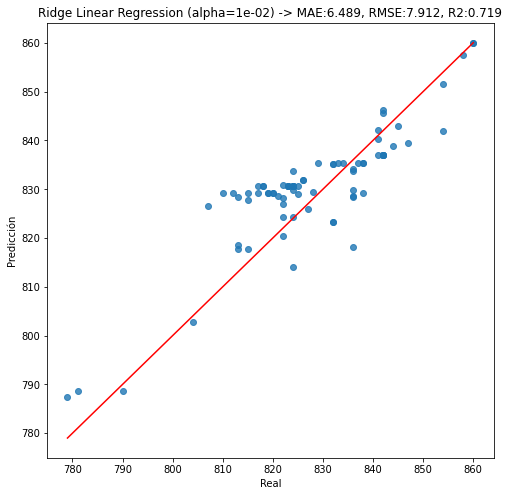

In [18]:
model = Ridge(alpha=1e-02)
mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, y_val, pred_val, y_test, preds_test, val_mat, tst_mat = entrena_model(model)
dibuja_preds(y_test, preds_test, mae_tst, rmse_tst, r2_tst, 'Ridge Linear Regression (alpha=1e-02) -> ')

Vamos a visualizar la distribución de los errrores de validación cruzada

In [19]:
def saca_predicciones(y_true, y_pred):
    errores = y_true-y_pred
    fig, ax = plt.subplots(figsize=(10,10))
    plt.subplot(2,2,1)
    sns.kdeplot(y_true)
    plt.title('BIAS={:,.3f}, VAR={:,.3f}'.format(np.mean(errores),np.var(errores)))
    plt.xlabel('Error')
    plt.ylabel('Prob')
    
    plt.subplot(2,2,2)
    sns.histplot(data=errores)
    plt.title('MIN_ABS={:,.3f}, MAX_ABS={:,.3f}'.format(np.min(np.abs(errores)),np.max(np.abs(errores))))
    plt.xlabel('Error')
    plt.ylabel('Num')
    
    plt.subplot(2,2,3)
    min_x, max_x = y_true.min(), y_true.max()
    min_y, max_y = y_pred.min(), y_pred.max()
    min_tot = min(min_x,min_y)
    max_tot = max(max_x,max_y)
    plt.scatter(y_true[np.argsort(y_true)],y_pred[np.argsort(y_true)],alpha=0.80)
    plt.plot([min_tot, max_tot],[min_tot, max_tot], color='red')
    plt.xlabel('Real')
    plt.ylabel('Predicción')
    
    ax1 = plt.subplot(2,2,4)
    df = pd.DataFrame({'Real':y_true,'Prediccion':y_pred})
    sns.kdeplot(df.Real, df.Prediccion, ax=ax1)
    sns.rugplot(df.Real, color="g", ax=ax1)
    sns.rugplot(df.Prediccion, ax=ax1)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


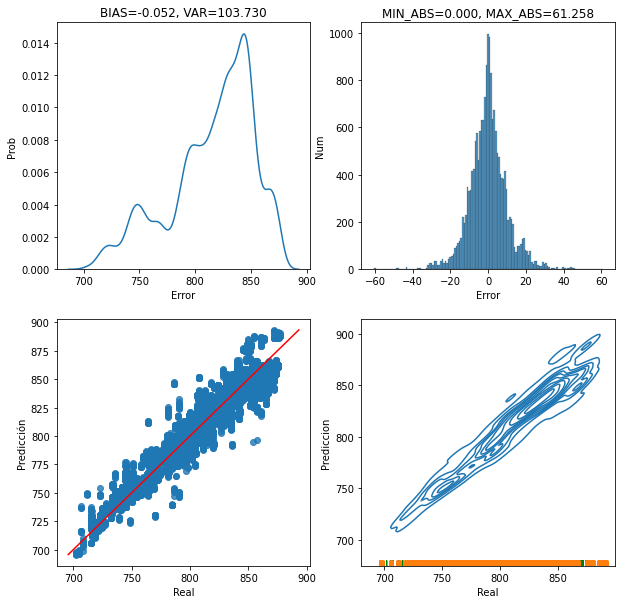

In [20]:
# Visualiza los errores de validación cruzada repetida 10 veces
num_bags = 10
y_true_rep = np.array(list(y_val)*num_bags) # Repite el target 'num_bags' veces
y_pred_val_flatten = val_mat.flatten(order='F') # sacar un vector con todas las preds
saca_predicciones(y_true_rep, y_pred_val_flatten)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


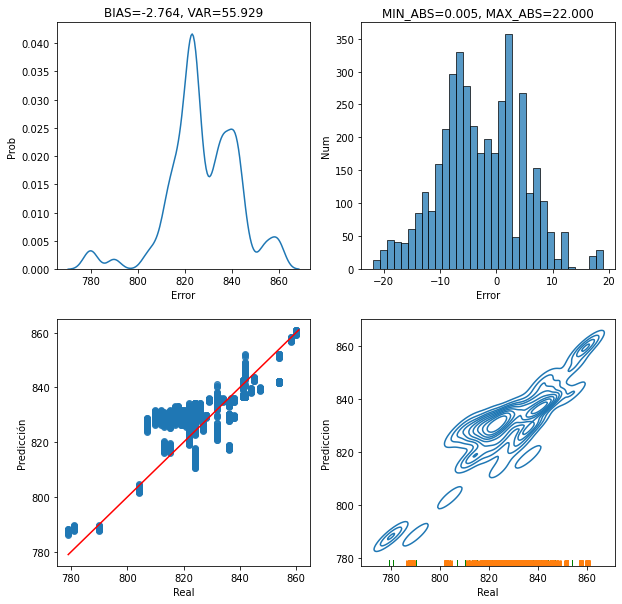

In [21]:
# Visualiza los errores de testeo
num_bags = 10
num_folds = 5
y_true_rep = np.array(list(y_test)*num_bags*num_folds) # Repite el target 'num_bags'*'num_folds' veces
y_pred_tst_flatten = tst_mat.flatten(order='F') # sacar un vector con todas las preds
saca_predicciones(y_true_rep, y_pred_tst_flatten)

**EJERCICIO: Interpreta las gráficas anteriores. ¿Para qué sirven? Si te fijas en los errores de validación, ¿Crees que el modelo subestima? Si es así, ¿Dónde? ¿Y sobreestima? Si es así, ¿Dónde?. Justifica tu respuesta**

Son en orden (de izquierde a derecha, de arriba a abajo):


1.   Distribución de errores (arriba a la izquierda)
2.   Cantidad de errores (arriba a la derecha)
3.   Errores de validación (abajo a la izquierda)
4.   Densidad de puntos (abajo a la derecha)

validación cruzada: ni subestima ni sobreestima, porque se puede ver en la gráfica de Errores de validación (abajo a la izquierda) hay igual numero de puntos por encima que por debajo de la linea de frontera de decisión

testeo: sobreestima, porque se puede ver en la gráfica de Errores de validación (abajo a la izquierda) que hay más puntos por encima de la linea de frontera de decisión, se puede apreciar en el eje y = 820 y eje x = 820


### Selección del Mejor Número de Folds

Aunque hemos elegido inicialmente 5 folds, surge la duda de si este número es la mejor elección. En el siguiente código ejecutamos el modelo con diferente número de folds para una sola repetición (num_bags=1) y visualizamos el sesgo (BIAS) y varianza de los errores obtenidos.

In [22]:
model = Ridge(alpha=1e-02)
for nfolds in np.arange(2,21):
    _, _, _, _, _, _, y_val, _, _, _, val_mat, tst_mat = entrena_model(model, num_folds=nfolds, num_bags=1)
    y_pred_val_mean = np.mean(val_mat,axis=1) # sacar un vector con todas las preds
    errores = y_val-y_pred_val_mean # Obtenemos los errores
    print('NFOLDS={} ERRORES [BIAS={:,.3f},VAR={:,.3f}]'.format(nfolds,np.mean(errores),np.var(errores)))

NFOLDS=2 ERRORES [BIAS=-0.193,VAR=107.430]
NFOLDS=3 ERRORES [BIAS=-0.119,VAR=103.818]
NFOLDS=4 ERRORES [BIAS=-0.077,VAR=104.748]
NFOLDS=5 ERRORES [BIAS=-0.023,VAR=101.225]
NFOLDS=6 ERRORES [BIAS=-0.061,VAR=105.235]
NFOLDS=7 ERRORES [BIAS=-0.046,VAR=102.579]
NFOLDS=8 ERRORES [BIAS=-0.077,VAR=104.402]
NFOLDS=9 ERRORES [BIAS=-0.047,VAR=102.298]
NFOLDS=10 ERRORES [BIAS=-0.017,VAR=102.494]
NFOLDS=11 ERRORES [BIAS=-0.050,VAR=102.785]
NFOLDS=12 ERRORES [BIAS=-0.026,VAR=102.890]
NFOLDS=13 ERRORES [BIAS=-0.025,VAR=102.639]
NFOLDS=14 ERRORES [BIAS=-0.024,VAR=102.438]
NFOLDS=15 ERRORES [BIAS=-0.034,VAR=102.746]
NFOLDS=16 ERRORES [BIAS=-0.029,VAR=102.587]
NFOLDS=17 ERRORES [BIAS=-0.036,VAR=102.747]
NFOLDS=18 ERRORES [BIAS=-0.025,VAR=103.137]
NFOLDS=19 ERRORES [BIAS=-0.030,VAR=102.709]
NFOLDS=20 ERRORES [BIAS=-0.029,VAR=103.252]


**RESPONDE A LAS SIGUIENTES CUESTIONES: ¿Cuál crees que es la mejor elección en este caso? ¿Por qué? Justifica tu respuesta.**

En NFOLDS = 10 ya que tiene el menor BIAS y una varianza alta

**RESPONDE A LAS SIGUIENTES CUESTIONES: Ejecuta el código anterior pero con *num_bags*=10. Compara los resultados con los obtenidos antes ¿Qué es lo que pasa? ¿Que *k* elegirías ahora? Justifica tu respuesta.**

In [23]:
model = Ridge(alpha=1e-02)
for nfolds in np.arange(2,21):
    _, _, _, _, _, _, y_val, _, _, _, val_mat, tst_mat = entrena_model(model, num_folds=nfolds, num_bags=10)
    y_pred_val_mean = np.mean(val_mat,axis=1) # sacar un vector con todas las preds
    errores = y_val-y_pred_val_mean # Obtenemos los errores
    print('NFOLDS={} ERRORES [BIAS={:,.3f},VAR={:,.3f}]'.format(nfolds,np.mean(errores),np.var(errores)))

NFOLDS=2 ERRORES [BIAS=-0.103,VAR=102.912]
NFOLDS=3 ERRORES [BIAS=-0.072,VAR=102.846]
NFOLDS=4 ERRORES [BIAS=-0.057,VAR=102.633]
NFOLDS=5 ERRORES [BIAS=-0.052,VAR=102.397]
NFOLDS=6 ERRORES [BIAS=-0.053,VAR=102.771]
NFOLDS=7 ERRORES [BIAS=-0.043,VAR=102.504]
NFOLDS=8 ERRORES [BIAS=-0.057,VAR=102.585]
NFOLDS=9 ERRORES [BIAS=-0.041,VAR=102.596]
NFOLDS=10 ERRORES [BIAS=-0.038,VAR=102.909]
NFOLDS=11 ERRORES [BIAS=-0.051,VAR=102.508]
NFOLDS=12 ERRORES [BIAS=-0.049,VAR=102.816]
NFOLDS=13 ERRORES [BIAS=-0.039,VAR=102.907]
NFOLDS=14 ERRORES [BIAS=-0.039,VAR=102.601]
NFOLDS=15 ERRORES [BIAS=-0.035,VAR=102.960]
NFOLDS=16 ERRORES [BIAS=-0.048,VAR=102.739]
NFOLDS=17 ERRORES [BIAS=-0.037,VAR=102.732]
NFOLDS=18 ERRORES [BIAS=-0.040,VAR=102.687]
NFOLDS=19 ERRORES [BIAS=-0.037,VAR=102.803]
NFOLDS=20 ERRORES [BIAS=-0.039,VAR=102.999]


En NFOLDS = 15 ya que tiene el menor BIAS y una varianza alta

### Modelo Final Lineal de Ridge Regression

Buscamos de nuevo el mejor modelo con el valor de *k* que elija el estudiante.

In [24]:
from sklearn.linear_model import Ridge
k_elegido = 15 # CAMBIAR AL ELEGIDO POR EL ESTUDIANTE
# Probamos con diferentes potencias de 10
for alpha in np.power(10.0,np.arange(-2,3,0.3)):
    model = Ridge(alpha=alpha)
    mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, _, _, _, _, _, _ = entrena_model(model, num_folds=k_elegido)
    print('RIDGE con alpha={:.1e} ->\
    Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
    Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(alpha, 
                                                      mae_val, rmse_val, r2_val, 
                                                      mae_tst, rmse_tst, r2_tst))

RIDGE con alpha=1.0e-02 ->    Val:[MAE=7.339,RMSE=10.147,R2=0.927]     Test:[MAE=6.496,RMSE=7.918,R2=0.718]
RIDGE con alpha=2.0e-02 ->    Val:[MAE=7.339,RMSE=10.147,R2=0.927]     Test:[MAE=6.496,RMSE=7.918,R2=0.718]
RIDGE con alpha=4.0e-02 ->    Val:[MAE=7.339,RMSE=10.147,R2=0.927]     Test:[MAE=6.496,RMSE=7.918,R2=0.718]
RIDGE con alpha=7.9e-02 ->    Val:[MAE=7.339,RMSE=10.147,R2=0.927]     Test:[MAE=6.495,RMSE=7.917,R2=0.718]
RIDGE con alpha=1.6e-01 ->    Val:[MAE=7.339,RMSE=10.147,R2=0.927]     Test:[MAE=6.494,RMSE=7.916,R2=0.719]
RIDGE con alpha=3.2e-01 ->    Val:[MAE=7.339,RMSE=10.147,R2=0.927]     Test:[MAE=6.492,RMSE=7.914,R2=0.719]
RIDGE con alpha=6.3e-01 ->    Val:[MAE=7.339,RMSE=10.147,R2=0.927]     Test:[MAE=6.487,RMSE=7.909,R2=0.719]
RIDGE con alpha=1.3e+00 ->    Val:[MAE=7.340,RMSE=10.147,R2=0.927]     Test:[MAE=6.480,RMSE=7.900,R2=0.720]
RIDGE con alpha=2.5e+00 ->    Val:[MAE=7.342,RMSE=10.148,R2=0.927]     Test:[MAE=6.466,RMSE=7.881,R2=0.721]
RIDGE con alpha=5.0e+00 ->  

**RESPONDE A LAS SIGUIENTE CUESTIÓN: ¿Por qué no elegimos el modelo que tiene el mejor RMSE de testeo?**

Ya que al haber bastante diferencia entre el de validación y testeo, puede llegar a producirse un sobreajuste (7.355 frente a 10.647)

### Modelo K-NN

In [25]:
from sklearn.neighbors import KNeighborsClassifier
for n_neighbors in range(8):
    model = KNeighborsClassifier(n_neighbors=n_neighbors+1) 
    mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, _, _, _, _, _, _ = entrena_model(model, num_folds=k_elegido)
    print('KNN con k={} vecinos -> \
    Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
    Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(n_neighbors+1, mae_val, rmse_val, r2_val, 
                                                      mae_tst, rmse_tst, r2_tst))

KNN con k=1 vecinos ->     Val:[MAE=5.770,RMSE=10.945,R2=0.915]     Test:[MAE=10.747,RMSE=12.527,R2=0.295]
KNN con k=2 vecinos ->     Val:[MAE=6.243,RMSE=11.564,R2=0.906]     Test:[MAE=10.481,RMSE=12.661,R2=0.280]
KNN con k=3 vecinos ->     Val:[MAE=6.979,RMSE=13.224,R2=0.876]     Test:[MAE=9.906,RMSE=12.699,R2=0.276]
KNN con k=4 vecinos ->     Val:[MAE=7.221,RMSE=13.592,R2=0.869]     Test:[MAE=14.971,RMSE=18.826,R2=-0.592]
KNN con k=5 vecinos ->     Val:[MAE=7.358,RMSE=14.011,R2=0.861]     Test:[MAE=15.462,RMSE=20.633,R2=-0.912]
KNN con k=6 vecinos ->     Val:[MAE=7.600,RMSE=14.372,R2=0.854]     Test:[MAE=15.688,RMSE=20.770,R2=-0.938]
KNN con k=7 vecinos ->     Val:[MAE=7.713,RMSE=14.533,R2=0.851]     Test:[MAE=15.580,RMSE=20.625,R2=-0.911]
KNN con k=8 vecinos ->     Val:[MAE=7.984,RMSE=14.915,R2=0.843]     Test:[MAE=15.136,RMSE=20.146,R2=-0.823]


Analizando los resultados elegimos el modelo con k vecinos que **tenga menor RMSE de validación cruzada**.

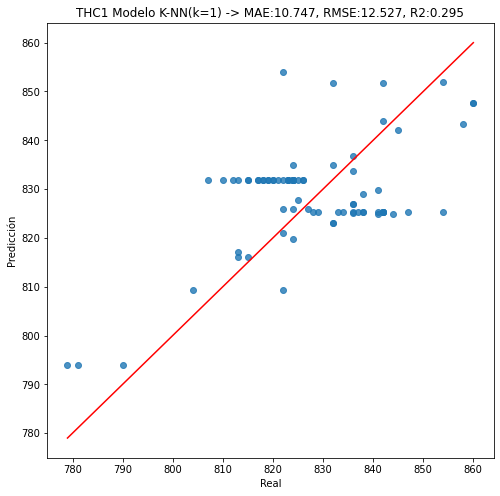

In [26]:
model = KNeighborsClassifier(n_neighbors=1) 
mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, y_val, pred_val, y_test, preds_test, val_mat, tst_mat = entrena_model(model, num_folds=k_elegido)
dibuja_preds(y_test, preds_test, mae_tst, rmse_tst, r2_tst, 'THC1 Modelo K-NN(k=1) -> ')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


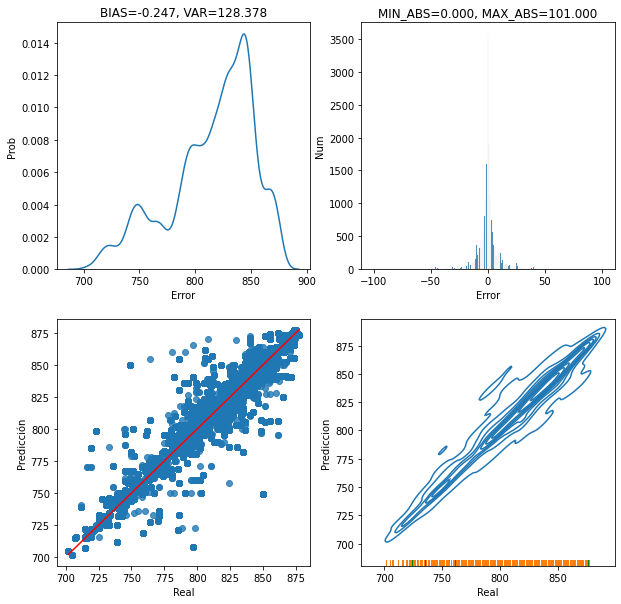

In [27]:
# Visualiza los errores de validación cruzada repetida 15 veces
num_bags = 10
y_true_rep = np.array(list(y_val)*num_bags) # Repite el target 'num_bags' veces
y_pred_val_flatten = val_mat.flatten(order='F') # sacar un vector con todas las preds
saca_predicciones(y_true_rep, y_pred_val_flatten)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


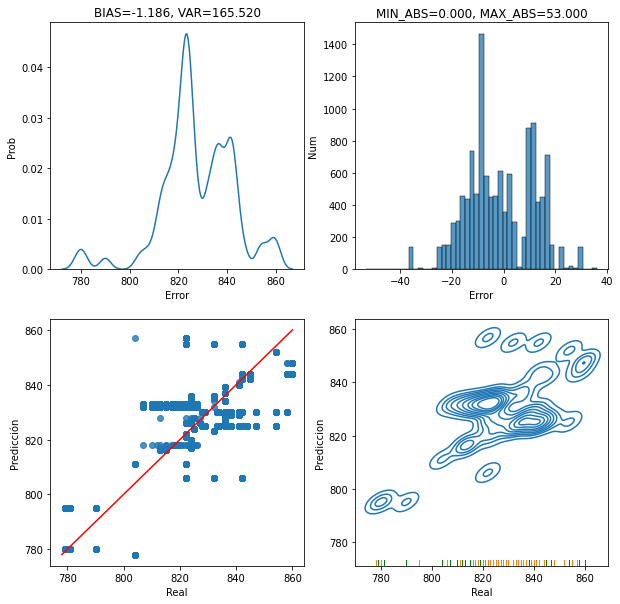

In [28]:
# Visualiza los errores de testeo
num_bags = 10
num_folds = k_elegido
y_true_rep = np.array(list(y_test)*num_bags*num_folds) # Repite el target 'num_bags'*'num_folds' veces
y_pred_tst_flatten = tst_mat.flatten(order='F') # sacar un vector con todas las preds
saca_predicciones(y_true_rep, y_pred_tst_flatten)

**RESPONDE A LA SIGUIENTES CUESTIÓN: KNN tiene un MAE de validación mejor que el modelo RIDGE aunque un RMSE de validación ligeramente peor. Sin embargo, los errores de testeo del KNN son mucho mayores que los del modelo RIDGE. ¿Por qué crees que pasa esto? Justifica tu respuesta.**

Porque el modelo KNN no aprende nada (es todo calculo)


### Modelo ANN

Vamos a usar modelo de redes neuronales para regresión. La función *MLPRegressor()* dispone de diferentes 'solvers' para el entrenamiento de la red neuronal. Habitualmente, el solver 'Adam' (y sus variantes) funciona bastante bien con bases de datos grandes. Para bases de datos pequeñas, el método 'lbfgs' puede converger más rápido y es mucho más fácil de entrenar.
MLPRegressor utiliza por defecto funciones de activación 'relu'.

Vamos a buscar el tamaño de red más adecuado considerando una sola capa oculta.

**OJO!: Todos los resultados siguientes pueden cambiar según el *k* fold elegido**

In [29]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.neural_network import MLPRegressor
for num_neuronas in np.arange(1,51,5):
    model = MLPRegressor(hidden_layer_sizes=(num_neuronas,), solver='lbfgs')
    mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, _, _, _, _, _, _ = entrena_model(model, num_folds=k_elegido)
    print('ANN con num_neuronas={} -> \
    Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
    Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(num_neuronas,
                                                      mae_val, rmse_val, r2_val, 
                                                      mae_tst, rmse_tst, r2_tst))

ANN con num_neuronas=1 ->     Val:[MAE=17.420,RMSE=43.811,R2=-0.356]     Test:[MAE=7.817,RMSE=9.947,R2=0.556]
ANN con num_neuronas=6 ->     Val:[MAE=8.488,RMSE=27.275,R2=0.474]     Test:[MAE=5.928,RMSE=7.329,R2=0.759]
ANN con num_neuronas=11 ->     Val:[MAE=7.773,RMSE=19.331,R2=0.736]     Test:[MAE=5.770,RMSE=7.136,R2=0.771]
ANN con num_neuronas=16 ->     Val:[MAE=7.122,RMSE=12.267,R2=0.894]     Test:[MAE=5.443,RMSE=6.788,R2=0.793]
ANN con num_neuronas=21 ->     Val:[MAE=6.793,RMSE=10.020,R2=0.929]     Test:[MAE=5.308,RMSE=6.689,R2=0.799]
ANN con num_neuronas=26 ->     Val:[MAE=6.857,RMSE=10.977,R2=0.915]     Test:[MAE=5.402,RMSE=6.817,R2=0.791]
ANN con num_neuronas=31 ->     Val:[MAE=6.898,RMSE=11.441,R2=0.908]     Test:[MAE=5.343,RMSE=6.795,R2=0.793]
ANN con num_neuronas=36 ->     Val:[MAE=7.195,RMSE=15.531,R2=0.830]     Test:[MAE=5.355,RMSE=6.771,R2=0.794]
ANN con num_neuronas=41 ->     Val:[MAE=7.215,RMSE=16.499,R2=0.808]     Test:[MAE=5.303,RMSE=6.722,R2=0.797]
ANN con num_neurona

Probamos a cambiar la función de activación por una sigmoidea (activation='logistic') pues suele funcionar bien y es más estable en bases de datos estandarizadas y con pocas variables.

In [30]:
from sklearn.neural_network import MLPRegressor
for num_neuronas in np.arange(1,51,5):
    model = MLPRegressor(hidden_layer_sizes=(num_neuronas,), solver='lbfgs', activation='logistic')
    mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, _, _, _, _, _, _ = entrena_model(model, num_folds=k_elegido)
    print('ANN con num_neuronas={} -> \
    Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
    Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(num_neuronas,
                                                      mae_val, rmse_val, r2_val, 
                                                      mae_tst, rmse_tst, r2_tst))

ANN con num_neuronas=1 ->     Val:[MAE=22.699,RMSE=28.789,R2=0.414]     Test:[MAE=11.168,RMSE=14.200,R2=0.094]
ANN con num_neuronas=6 ->     Val:[MAE=9.128,RMSE=14.633,R2=0.849]     Test:[MAE=6.146,RMSE=7.411,R2=0.753]
ANN con num_neuronas=11 ->     Val:[MAE=5.730,RMSE=11.236,R2=0.911]     Test:[MAE=5.357,RMSE=6.529,R2=0.809]
ANN con num_neuronas=16 ->     Val:[MAE=5.310,RMSE=9.100,R2=0.941]     Test:[MAE=4.740,RMSE=6.224,R2=0.826]
ANN con num_neuronas=21 ->     Val:[MAE=5.277,RMSE=10.133,R2=0.927]     Test:[MAE=4.651,RMSE=6.443,R2=0.814]
ANN con num_neuronas=26 ->     Val:[MAE=5.285,RMSE=10.355,R2=0.924]     Test:[MAE=4.806,RMSE=6.674,R2=0.800]
ANN con num_neuronas=31 ->     Val:[MAE=5.342,RMSE=10.994,R2=0.915]     Test:[MAE=5.116,RMSE=6.881,R2=0.787]
ANN con num_neuronas=36 ->     Val:[MAE=5.388,RMSE=11.327,R2=0.909]     Test:[MAE=5.067,RMSE=6.898,R2=0.786]
ANN con num_neuronas=41 ->     Val:[MAE=5.474,RMSE=12.431,R2=0.891]     Test:[MAE=5.233,RMSE=7.050,R2=0.777]
ANN con num_neurona

Vemos que con funciones de activación sigmoidea el modelo con 16 neuronas obtiene el mejor RMSE de validación. Además, se observa que los modelos próximos, con 21 y 26 neuronas, son más estables con RMSE menores que los modelos con 'relu'.

Vamos a afinar un poco más la búsqueda.

In [31]:
# Afinamos en la búsqueda cerca de las 16 neuronas (menor RMSE de validación)
for num_neuronas in np.arange(12,21,1):
    model = MLPRegressor(hidden_layer_sizes=(num_neuronas,), solver='lbfgs', activation='logistic')
    mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, _, _, _, _, _, _ = entrena_model(model, num_folds=k_elegido)
    print('ANN con num_neuronas={} -> \
    Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
    Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(num_neuronas, mae_val, rmse_val, r2_val, 
                                                      mae_tst, rmse_tst, r2_tst))

ANN con num_neuronas=12 ->     Val:[MAE=5.442,RMSE=9.492,R2=0.936]     Test:[MAE=5.383,RMSE=6.533,R2=0.808]
ANN con num_neuronas=13 ->     Val:[MAE=5.339,RMSE=8.850,R2=0.945]     Test:[MAE=5.125,RMSE=6.381,R2=0.817]
ANN con num_neuronas=14 ->     Val:[MAE=5.455,RMSE=11.264,R2=0.910]     Test:[MAE=4.888,RMSE=6.187,R2=0.828]
ANN con num_neuronas=15 ->     Val:[MAE=5.391,RMSE=10.431,R2=0.923]     Test:[MAE=4.748,RMSE=6.143,R2=0.830]
ANN con num_neuronas=16 ->     Val:[MAE=5.310,RMSE=9.100,R2=0.941]     Test:[MAE=4.740,RMSE=6.224,R2=0.826]
ANN con num_neuronas=17 ->     Val:[MAE=5.154,RMSE=8.744,R2=0.946]     Test:[MAE=4.521,RMSE=6.123,R2=0.832]
ANN con num_neuronas=18 ->     Val:[MAE=5.250,RMSE=9.845,R2=0.932]     Test:[MAE=4.633,RMSE=6.230,R2=0.826]
ANN con num_neuronas=19 ->     Val:[MAE=5.264,RMSE=10.046,R2=0.929]     Test:[MAE=4.562,RMSE=6.256,R2=0.824]
ANN con num_neuronas=20 ->     Val:[MAE=5.282,RMSE=10.278,R2=0.925]     Test:[MAE=4.585,RMSE=6.306,R2=0.821]


Parece que con 16 neuronas seguimos teniendo el mejor RMSE y R2 de validación.

Vamos a intentar mejorar los resultados mediante *regularización* usando el párametro *alpha*. Este parámetro, usualmente denominado *L2 penaly* o *weight decay*, incluye en la función de pérdida (función *loss*), la suma del cuadrado de los pesos multiplicado por *alpha*, penalizando los modelos con pesos altos en el proceso de entrenamiento. Modelos con pesos más bajos son modelos más robustos, es decir, menos sensibles al ruido y los espurios. Para *alpha* probamos diferentes potencias de 10. También se podría probar con más o menos neuronas.

In [32]:
for num_neuronas in [16]:
    for alpha in np.power(10.0,np.arange(-7,3,1)):
        model = MLPRegressor(hidden_layer_sizes=(num_neuronas,), alpha=alpha, solver='lbfgs', activation='logistic')
        mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, _, _, _, _, _, _ = entrena_model(model, num_folds=k_elegido)
        print('ANN neuronas={} alpha={:,.1e} -> \
        Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
        Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(num_neuronas, alpha,
                                                          mae_val, rmse_val, r2_val, 
                                                          mae_tst, rmse_tst, r2_tst))

ANN neuronas=16 alpha=1.0e-07 ->         Val:[MAE=5.302,RMSE=9.079,R2=0.942]         Test:[MAE=4.747,RMSE=6.228,R2=0.826]
ANN neuronas=16 alpha=1.0e-06 ->         Val:[MAE=5.309,RMSE=9.093,R2=0.942]         Test:[MAE=4.741,RMSE=6.218,R2=0.826]
ANN neuronas=16 alpha=1.0e-05 ->         Val:[MAE=5.310,RMSE=9.077,R2=0.942]         Test:[MAE=4.727,RMSE=6.215,R2=0.826]
ANN neuronas=16 alpha=1.0e-04 ->         Val:[MAE=5.310,RMSE=9.100,R2=0.941]         Test:[MAE=4.740,RMSE=6.224,R2=0.826]
ANN neuronas=16 alpha=1.0e-03 ->         Val:[MAE=5.310,RMSE=9.102,R2=0.941]         Test:[MAE=4.702,RMSE=6.198,R2=0.827]
ANN neuronas=16 alpha=1.0e-02 ->         Val:[MAE=5.309,RMSE=9.125,R2=0.941]         Test:[MAE=4.730,RMSE=6.204,R2=0.827]
ANN neuronas=16 alpha=1.0e-01 ->         Val:[MAE=5.304,RMSE=9.094,R2=0.942]         Test:[MAE=4.720,RMSE=6.201,R2=0.827]
ANN neuronas=16 alpha=1.0e+00 ->         Val:[MAE=5.307,RMSE=9.156,R2=0.941]         Test:[MAE=4.670,RMSE=6.179,R2=0.828]
ANN neuronas=16 alpha=1.

In [33]:
# En este caso, mejoramos un poco:
# ANN neuronas=17 alpha=1.0e-05
alpha = 1e-05
model = MLPRegressor(hidden_layer_sizes=(16,), alpha=alpha, solver='lbfgs', activation='logistic')
mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, y_val, pred_val, y_test, preds_test, val_mat, tst_mat = entrena_model(model, num_folds=k_elegido)
print('ANN neuronas={} alpha={:,.1e} -> \
    Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
    Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(num_neuronas, alpha,
                                                      mae_val, rmse_val, r2_val, 
                                                      mae_tst, rmse_tst, r2_tst))


ANN neuronas=16 alpha=1.0e-05 ->     Val:[MAE=5.310,RMSE=9.077,R2=0.942]     Test:[MAE=4.727,RMSE=6.215,R2=0.826]


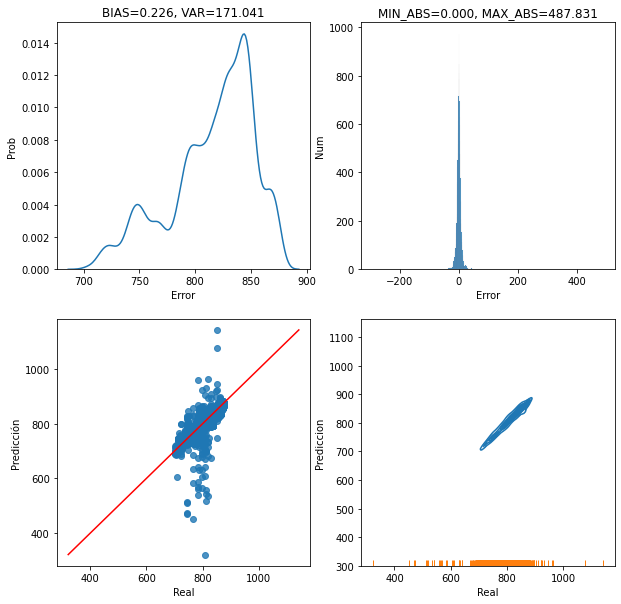

In [34]:
# Visualiza los errores de validación cruzada repetida
num_bags = 10
y_true_rep = np.array(list(y_val)*num_bags) # Repite el target 'num_bags' veces
y_pred_val_flatten = val_mat.flatten(order='F') # sacar un vector con todas las preds
saca_predicciones(y_true_rep, y_pred_val_flatten)

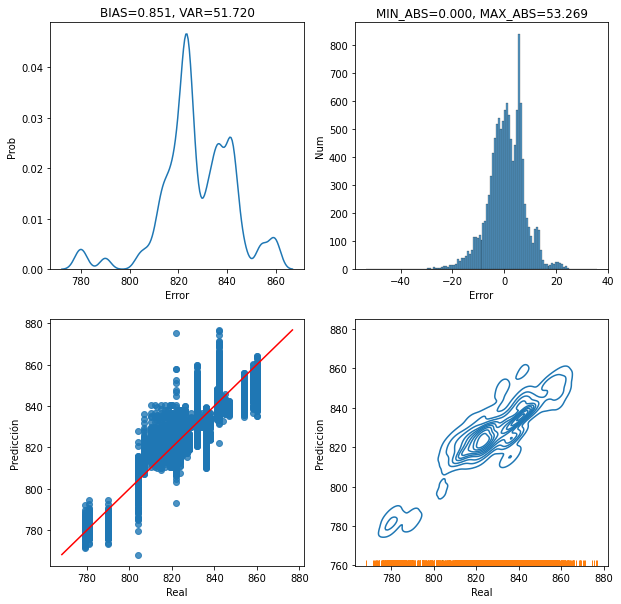

In [35]:
# Visualiza los errores de testeo
num_bags = 10
num_folds = k_elegido
y_true_rep = np.array(list(y_test)*num_bags*num_folds) # Repite el target 'num_bags'*'num_folds' veces
y_pred_tst_flatten = tst_mat.flatten(order='F') # sacar un vector con todas las preds
saca_predicciones(y_true_rep, y_pred_tst_flatten)

**EJERCICIO: Utilizando la metodología mostrada en las celdas anteriores buscar el mejor modelo SVR (sklearn.svm.SVR()) con kernel RBF y el mejor árbol de regresión (sklearn.tree.DecisionTreeRegressor()).**

In [36]:
from sklearn.svm import SVR
for num_neuronas in np.arange(1,27,5):
    model = SVR(kernel='rbf')
    mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, _, _, _, _, _, _ = entrena_model(model, num_folds=k_elegido)
    print('ANN con num_neuronas={} -> \
    Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
    Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(num_neuronas, mae_val, rmse_val, r2_val, 
                                                      mae_tst, rmse_tst, r2_tst))

ANN con num_neuronas=1 ->     Val:[MAE=14.154,RMSE=19.633,R2=0.728]     Test:[MAE=11.421,RMSE=13.302,R2=0.205]
ANN con num_neuronas=6 ->     Val:[MAE=14.154,RMSE=19.633,R2=0.728]     Test:[MAE=11.421,RMSE=13.302,R2=0.205]
ANN con num_neuronas=11 ->     Val:[MAE=14.154,RMSE=19.633,R2=0.728]     Test:[MAE=11.421,RMSE=13.302,R2=0.205]
ANN con num_neuronas=16 ->     Val:[MAE=14.154,RMSE=19.633,R2=0.728]     Test:[MAE=11.421,RMSE=13.302,R2=0.205]
ANN con num_neuronas=21 ->     Val:[MAE=14.154,RMSE=19.633,R2=0.728]     Test:[MAE=11.421,RMSE=13.302,R2=0.205]
ANN con num_neuronas=26 ->     Val:[MAE=14.154,RMSE=19.633,R2=0.728]     Test:[MAE=11.421,RMSE=13.302,R2=0.205]
ANN con num_neuronas=31 ->     Val:[MAE=14.154,RMSE=19.633,R2=0.728]     Test:[MAE=11.421,RMSE=13.302,R2=0.205]
ANN con num_neuronas=36 ->     Val:[MAE=14.154,RMSE=19.633,R2=0.728]     Test:[MAE=11.421,RMSE=13.302,R2=0.205]
ANN con num_neuronas=41 ->     Val:[MAE=14.154,RMSE=19.633,R2=0.728]     Test:[MAE=11.421,RMSE=13.302,R2=0

In [1]:
from sklearn.tree import DecisionTreeRegressor
for num_neuronas in np.arange(1,27,5):
    model = DecisionTreeRegressor()
    mae_val, rmse_val, r2_val, mae_tst, rmse_tst, r2_tst, _, _, _, _, _, _ = entrena_model(model, num_folds=k_elegido)
    print('ANN con num_neuronas={} -> \
    Val:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}] \
    Test:[MAE={:.3f},RMSE={:,.3f},R2={:,.3f}]'.format(num_neuronas, mae_val, rmse_val, r2_val, 
                                                      mae_tst, rmse_tst, r2_tst))

NameError: ignored

**EJERCICIO: En una tabla incluye los errores MAE y RMSE de validación y testeo del mejor modelo de cada tipo. Así mismo, incluye el porcentaje de errores de testeo que han superado los 25 grados en valor absoluto. Compara los errores de testeo obtenidos con Python frente a los modelos obtenidos con WEKA en la práctica anterior.**

**CUESTIONES: ¿Qué modelo elegirías finalmente? Justifica tu respuesta.**

**EJERCICIO FINAL: ¿Te sientes capaz de mejorar los resultados añadiendo nuevas características (features) o probando otras técnicas?**

# ENTREGA

Recuerda guardar tus cambios en tu repositorio utilizando la opción "Save a copy in GitHub..." del menú File.